- title: Permutation Importance
- date: 2020-04-05 12:00
- category: Machine learning
- tags: ml explainability, sklearn, pandas
- slug: permutation-importance
- authors: Chris Rinaldi
- summary: A quick look at calculating permutation importance

**Permutation Importance** is a way to better understand what features in your model have the most impact when predicting the target variable. In other words, it is a way to measure **feature importance**.

Conceptually, it is easy to understand and can be applied to any model. There is also a nice Python package, [eli5](https://eli5.readthedocs.io/en/latest/index.html) to calculate it.

# Create Datasets

This isn't the point of this post, but we'll be using the [California Housing Dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html). Let's quickly create the necessary datasets we'll be needing.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import sklearn
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

def init_data():
    """Fetch the California data and create Pandas DataFrame."""
    raw_data = fetch_california_housing()
    data = pd.DataFrame(raw_data['data'], columns=raw_data['feature_names'])
    data['Price'] = raw_data['target']
    return data

def create_datasets(data, validation_frac=0.2):
    """Create training and validation datasets."""
    y = data['Price']
    X = data.drop(columns=['Price'])
    return train_test_split(X, y, test_size=validation_frac, shuffle=True)

data = init_data()
X_train, X_val, y_train, y_val = create_datasets(data)

print(X_train.shape)
X_train.head()

(16512, 8)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
20307,2.6098,18.0,3.706056,1.016248,3129.0,4.621861,34.15,-119.17
2005,0.7990,25.0,3.645435,1.150743,1343.0,2.851380,36.74,-119.80
8296,4.3889,52.0,4.290064,1.028846,1144.0,1.833333,33.76,-118.14
3476,8.1248,18.0,7.851309,1.021990,3189.0,3.339267,34.32,-118.52
5901,2.4074,24.0,3.333333,1.050401,2522.0,2.888889,34.17,-118.31


In [2]:
y_train.head()

20307    1.461
2005     0.518
8296     3.780
3476     3.740
5901     2.194
Name: Price, dtype: float64

# Train a RandomForest Model

Also not the point of this post, but we need a trained model for which we want to evaluate the **permutation importance** for. In this case, we'll be using **sklearn**'s `RandomForestRegressor`, and evaluating its predictions using `mean_absolute_error()`.

In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

def train_model_and_predict(X_train, y_train, X_val):
    model = RandomForestRegressor()
    model.fit(X_train, y_train)
    return model, model.predict(X_val)

baseline_pred = y_train.mean()
model, preds = train_model_and_predict(X_train, y_train, X_val)

# Evaluate MAE of predictions
baseline_mae = mean_absolute_error([baseline_pred] * len(y_val), y_val)
mae = mean_absolute_error(preds, y_val)
print(f'Baseline MAE on validation dataset: {baseline_mae:.3f}.')
print(f'RF MAE on validation dataset: {mae:.3f}')

Baseline MAE on validation dataset: 0.922.
RF MAE on validation dataset: 0.328


# Permutation Importance

Permtuation Importance allows us to answer the question, "how would our model have performed if it didn't have access to a particular feature?". Conceptually, more important features will be the ones that have the largest impact when removed from the modeling process.

To actually do this, we will do the following:

1. Take the trained model
2. Randomly shuffle 1 column
3. Create predictions using this new dataset 
4. Calculate the MAE of our predictions
5. Subtract the new MAE (which should be higher) from our original MAE

Randomly shuffling the feature has the same impact as removing it, since we are completely destroying the relationship with the outcome variable of interest. 

In [4]:
import numpy as np

def shuffle_column(df, column):
    """Shuffle a single column of a DataFrame, return a copy."""
    result = df.copy()
    result[column] = np.random.permutation(df[column].values)
    return result


def calc_feature_permutation_mae(model, X, y, feature):
    """Calculate the MAE after permuting a particular feature."""
    X_shuffled = shuffle_column(X, feature)
    preds_shuffled = model.predict(X_shuffled)
    return mean_absolute_error(preds_shuffled, y)


def calc_permutation_importance(model, X, y):
    """Calculate Permutation Importance for all model features."""
    importances = {}
    preds = model.predict(X)
    mae = mean_absolute_error(preds, y)
    for feature in X:
        importances[feature] = calc_feature_permutation_mae(model, X, y, feature) - mae
    return sorted(importances.items(), key=lambda x: x[1], reverse=True)

[('MedInc', 0.4656078229006018), ('Latitude', 0.3681427987533668), ('Longitude', 0.313516140948717), ('AveOccup', 0.15820252426438614), ('HouseAge', 0.05195238744685643), ('AveRooms', 0.03337708491198049), ('AveBedrms', 0.009278008643218094), ('Population', 0.006155723338973851)]


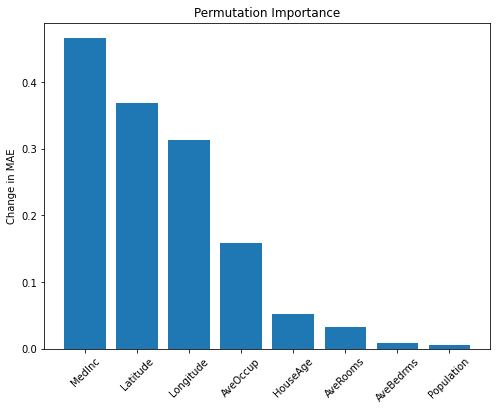

In [5]:
import matplotlib.pyplot as plt

result = calc_permutation_importance(model, X_val, y_val)
print(result)

features = [x[0] for x in result]
importances = [x[1] for x in result]
plt.figure(figsize=(8, 6))
plt.bar(features, importances)
plt.xticks(rotation=45)
plt.title('Permutation Importance')
plt.ylabel('Change in MAE')
plt.show()

We see that for our model, the most importance features are:
- MedInc
- Latitude
- Longitude

**Permutation Importance** found that if we removed the above features, the model's performance degrades the most. Conversely, it found we could drop the **Population** feature and not lose any predictive power.

# ELI5 and Permutation Importance

[eli5](https://eli5.readthedocs.io/en/latest/index.html) is a Python package that makes it simple to calculate **permutation importance** (amongst other things). If we use `neg_mean_absolute_error` as our scoring function, you'll see that we get values very similar to the ones we calcualted above. It also includes a measure of uncertainty, since it repated the permutation process multiple times.

In [6]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(model, scoring='neg_mean_absolute_error').fit(X_val, y_val)
eli5.show_weights(perm, feature_names=X_val.columns.tolist())

Weight,Feature
0.4718 ± 0.0103,MedInc
0.3635 ± 0.0079,Latitude
0.3101 ± 0.0111,Longitude
0.1623 ± 0.0077,AveOccup
0.0566 ± 0.0036,HouseAge
0.0355 ± 0.0021,AveRooms
0.0091 ± 0.0005,AveBedrms
0.0078 ± 0.0022,Population
